### Pós-graduação em Ciência de Dados e Machine Learning

#### Disciplina: **Introdução a Redes Neurais**

#### Projeto Final para disciplina Introdução a Redes Neurais

<BR>
    
### **Integrantes**:
#### Nome:  Gustavo Gomes Balbino
#### RA: 52400106

#### Nome:  Gustavo Lopes Urio Fonseca
#### RA: 52400113
---

# Classificação de Tumores de Mama em Imagens de Ultrassom

**Objetivos**  
1. **Pré-processamento**: usar máscaras para recortar região de tumor.  
2. **Modelagem**: ResNet50 pré-treinada + blocos customizados (PDFBlock + SEBlock).  
3. **Treino**: otimizar usando loss binária, métricas AUC e acurácia.  
4. **Avaliação**: matriz de confusão, AUC e relatório de resultados.

**Métricas de Sucesso**  
- Acurácia ≥ X%  
- AUC ≥ Y%  
- Boa separação das classes (confusion matrix bem balanceada)

---
### **Passo 1:**
#### Vamos começar fazendo o download e importando as bibliotecas necessárias:

In [1]:
import gc
import tensorflow as tf

# Limpar sessão TensorFlow
tf.keras.backend.clear_session()

# Coletar lixo do Python
gc.collect()


2025-04-28 23:00:58.763548: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 23:00:58.784795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-28 23:00:58.784813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-28 23:00:58.785295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 23:00:58.789098: I tensorflow/core/platform/cpu_feature_guar

0

In [2]:
import os
import glob

# Removido: os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle as skshuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, Input, Model
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Dispositivos visíveis:", tf.config.list_physical_devices('GPU'))
print("Versão do TensorFlow:", tf.__version__)


Dispositivos visíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Versão do TensorFlow: 2.15.0


2025-04-28 23:01:00.316739: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 23:01:00.340232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 23:01:00.340265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 23:01:00.340269: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


---
### **Passo 2:**
#### Uma breve visualização do 'dataset.csv'

In [3]:
df = pd.read_csv('dataset.csv', sep=',')
df.head(10)

,Level,Name,Type,Description,File Count
0,0,.,directory,Root directory,2
1,1,images,directory,Contains all ultrasound images,811
2,1,masks,directory,Contains corresponding segmentation masks,811
3,1,Benign,directory,Contains benign tumor data,2
4,2,Benign/images,directory,Ultrasound images of benign tumors,358
5,2,Benign/masks,directory,Segmentation masks for benign tumors,358
6,1,Malignant,directory,Contains malignant tumor data,2
7,2,Malignant/images,directory,Ultrasound images of malignant tumors,453
8,2,Malignant/masks,directory,Segmentation masks for malignant tumors,453


##### Abaixo vamos listar imagens, máscaras e labels

In [4]:
BASE_DIR = "BUS_UC/BUS_UC/BUS_UC"
IMG_PATTERN = "*.png"

# diretórios
dirs = {
    0: (os.path.join(BASE_DIR, "Benign",    "images"),
        os.path.join(BASE_DIR, "Benign",    "masks")),
    1: (os.path.join(BASE_DIR, "Malignant", "images"),
        os.path.join(BASE_DIR, "Malignant", "masks")),
}

all_images, all_masks, all_labels = [], [], []
for label, (img_dir, mask_dir) in dirs.items():
    imgs  = sorted(glob.glob(os.path.join(img_dir,  IMG_PATTERN)))
    masks = sorted(glob.glob(os.path.join(mask_dir, IMG_PATTERN)))
    all_images += imgs
    all_masks  += masks
    all_labels += [label] * len(imgs)

print(f"Total: {len(all_images)} imagens, {len(all_masks)} máscaras")
print("Distribuição:", pd.Series(all_labels).value_counts().to_dict())

Total: 811 imagens, 811 máscaras
Distribuição: {1: 453, 0: 358}


---
### **Passo 3:**
#### Vamos agora embaralhar essas listas e separar para treino, validação e teste.

In [5]:
imgs, masks, labs = skshuffle(all_images, all_masks, all_labels, random_state=42)
X_train, X_rem, M_train, M_rem, y_train, y_rem = train_test_split(
    imgs, masks, labs,
    test_size=0.30, stratify=labs, random_state=42
)
X_val, X_test, M_val, M_test, y_val, y_test = train_test_split(
    X_rem, M_rem, y_rem,
    test_size=0.50, stratify=y_rem, random_state=42
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 567 | Val: 122 | Test: 122


In [6]:
IMG_SIZE = (224, 224)

def parse_image_mask(img_path, mask_path, label):
    # lê e normaliza imagem
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE) / 255.0

    # lê máscara e redimensiona
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE)

    # aplica máscara
    img = img * mask

    # AUGMENTAÇÃO APENAS NO TREINO
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_flip_left_right(img)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_flip_up_down(img)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_brightness(img, max_delta=0.15)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.random_saturation(img, lower=0.8, upper=1.2)

    return img, label

In [7]:
def make_dataset(imgs, masks, labels, batch_size=16, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((imgs, masks, labels))
    if shuffle:
        ds = ds.shuffle(len(imgs))
    ds = ds.map(lambda i, m, l: parse_image_mask(i, m, l),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, M_train, y_train)
val_ds = make_dataset(X_val, M_val, y_val, shuffle=False)
test_ds = make_dataset(X_test, M_test, y_test, shuffle=False)

# verificação rápida
for imgs, labs in train_ds.take(1):
    print("Batch imagens:", imgs.shape, "Batch labels:", labs.numpy())

2025-04-28 23:01:00.386443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 23:01:00.386485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 23:01:00.386498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 23:01:00.386501: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2025-04-28 23:01:00.570017: I external/lo

Batch imagens: (16, 224, 224, 3) Batch labels: [0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0]


---
### **Passo 4:**
#### Vamos definir o modelo e os blocos customizados

In [8]:
class SEBlock(layers.Layer):
    """Squeeze-and-Excitation: recalibra dinamicamente a importância dos canais."""
    def __init__(self, channels, reduction=16, **kwargs):
        super().__init__(**kwargs)
        self.global_pool = layers.GlobalAveragePooling2D()
        self.fc1         = layers.Dense(channels // reduction, activation="relu")
        self.fc2         = layers.Dense(channels,          activation="sigmoid")
        self.reshape     = layers.Reshape((1, 1, channels))
        self.multiply    = layers.Multiply()

    def call(self, x):
        se = self.global_pool(x)      # [B, C]
        se = self.fc1(se)             # [B, C/r]
        se = self.fc2(se)             # [B, C]
        se = self.reshape(se)         # [B, 1, 1, C]
        return self.multiply([x, se])

class PDFBlock(layers.Layer):
    """Pyramid-Dilated Fusion: múltiplas convoluções dilatadas + projeção 1×1."""
    def __init__(self, out_channels, kernel_sizes, dilations, **kwargs):
        super().__init__(**kwargs)
        assert len(kernel_sizes) == len(dilations), "kernel_sizes e dilations devem ter mesmo tamanho"
        self.branches = []
        for k, d in zip(kernel_sizes, dilations):
            self.branches.append(
                layers.Conv2D(
                    filters=out_channels,
                    kernel_size=k,
                    padding="same",
                    dilation_rate=d,
                    activation="relu"
                )
            )
        self.project = layers.Conv2D(filters=out_channels, kernel_size=1, activation="relu")

    def call(self, x):
        feats = [branch(x) for branch in self.branches]
        x_cat = tf.concat(feats, axis=-1)
        return self.project(x_cat)

In [9]:
# 1) Backbone ResNet50 sem top layer, retendo mapa espacial
# Usando EfficientNetB0 como backbone por ser mais leve e rápido
backbone = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3)
)
backbone.trainable = False  # congelado no início

# 2) Construção do grafo
inp = Input(shape=(*IMG_SIZE, 3), name="input_image")
x   = backbone(inp)                            # [B, H', W', C=2048]

# 3) Aplicar PDFBlock (multi‐escala)
x = PDFBlock(
    out_channels=512,
    kernel_sizes=[1, 3, 5, 7],
    dilations=[1, 2, 3, 4]
)(x)  # agora [B, H', W', 512]

# 4) Recalibração de canais via SEBlock
x = SEBlock(channels=512, reduction=16)(x)      # [B, H', W', 512]

# 5) Agregação e cabeça de classificação
x = layers.GlobalAveragePooling2D(name="gap")(x)  # [B, 512]
x = layers.Dense(256, activation="relu", name="fc1")(x)
x = layers.Dropout(0.5, name="dropout")(x)
out = layers.Dense(1, activation="sigmoid", name="output")(x)

model_clf = Model(inputs=inp, outputs=out, name="MobileNetV2_PDF_SE_Clf")

#Penalizar mais os erros
def focal_loss(alpha=0.55, gamma=2.):  
    """
    alpha > 0.5 favorece mais o foco na classe 1 (Malignant).
    """
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    
    return focal_loss_fixed

# 6) Compilação do modelo
model_clf.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(alpha=0.55, gamma=2.),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model_clf.summary()

Model: "MobileNetV2_PDF_SE_Clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 pdf_block (PDFBlock)        (None, 7, 7, 512)         56101376  
                                                                 
 se_block (SEBlock)          (None, 7, 7, 512)         33312     
                                                                 
 gap (GlobalAveragePooling2  (None, 512)               0         
 D)                                                              
                                                                 
 fc1 (Dense)                 (None, 256)    

---
### **Passo 5:**
#### Treino e monitoramento

In [10]:
callbacks_list = [
    callbacks.EarlyStopping(
        monitor="val_auc",
        patience=4,
        mode="max",
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        "best_model.h5",
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1
    )
]

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular pesos
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train  # (usa os labels do treino)
)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weights_dict)


{0: 1.134, 1: 0.8943217665615142}


In [12]:
history = model_clf.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks_list,
    class_weight=class_weights_dict
)

Epoch 1/30


2025-04-28 23:01:05.227966: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inMobileNetV2_PDF_SE_Clf/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-04-28 23:01:05.796070: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-28 23:01:07.403669: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f56b010cdb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-28 23:01:07.403697: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 5070 Ti, Compute Capability 12.0
2025-04-28 23:01:07.407374: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745892067.445836  142072 device_compi

36/36 [==============================] - ETA: 0s - loss: 0.0867 - accuracy: 0.5520 - auc: 0.5701
Epoch 1: val_auc improved from -inf to 0.64216, saving model to best_model.h5


/home/gustavo/.pyenv/versions/tf-gpu-env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 16s 163ms/step - loss: 0.0867 - accuracy: 0.5520 - auc: 0.5701 - val_loss: 0.0821 - val_accuracy: 0.5984 - val_auc: 0.6422
Epoch 2/30
30/36 [========================>.....] - ETA: 6s - loss: 0.0823 - accuracy: 0.6208 - auc: 0.6661
Epoch 2: val_auc improved from 0.64216 to 0.74169, saving model to best_model.h5
36/36 [==============================] - 2s 65ms/step - loss: 0.0833 - accuracy: 0.6049 - auc: 0.6501 - val_loss: 0.0764 - val_accuracy: 0.6393 - val_auc: 0.7417
Epoch 3/30
35/36 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.6679 - auc: 0.6990
Epoch 3: val_auc improved from 0.74169 to 0.75980, saving model to best_model.h5
36/36 [==============================] - 2s 65ms/step - loss: 0.0787 - accuracy: 0.6631 - auc: 0.6950 - val_loss: 0.0792 - val_accuracy: 0.6639 - val_auc: 0.7598
Epoch 4/30
35/36 [============================>.] - ETA: 0s - loss: 0.0761 - accuracy: 0.6696 - auc: 0.7314
Epoch 4: val_auc did not i

8/8 [==============================] - 1s 25ms/step
              precision    recall  f1-score   support

      Benign       0.55      0.72      0.62        54
   Malignant       0.71      0.53      0.61        68

    accuracy                           0.61       122
   macro avg       0.63      0.63      0.61       122
weighted avg       0.64      0.61      0.61       122



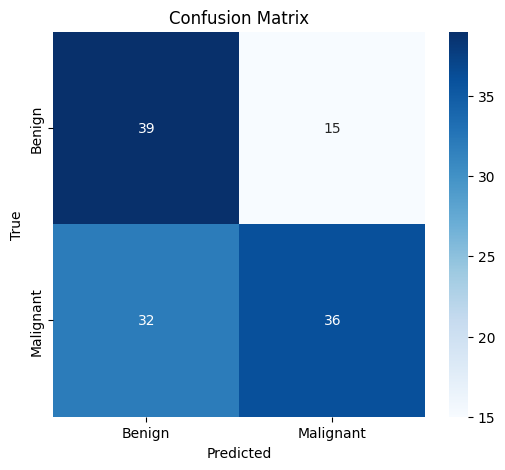

In [13]:
# Previsões
y_pred_prob = model_clf.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
y_true = np.concatenate([labels.numpy() for imgs, labels in test_ds], axis=0)

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [14]:
# Descongelar EfficientNetB0 a partir de 70% das camadas
fine_tune_at = int(len(backbone.layers) * 0.7)

for layer in backbone.layers[fine_tune_at:]:
    layer.trainable = True

# Recompilar o modelo com learning rate menor
model_clf.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)


In [15]:
# Treinar mais algumas épocas após liberar as camadas
history_finetune = model_clf.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks_list,
    class_weight=class_weights_dict  # Mantém pesos!
)


Epoch 1/5
36/36 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.6384 - auc: 0.6977
Epoch 1: val_auc did not improve from 0.75980
36/36 [==============================] - 6s 73ms/step - loss: 0.6536 - accuracy: 0.6384 - auc: 0.6977 - val_loss: 0.6408 - val_accuracy: 0.6639 - val_auc: 0.7563
Epoch 2/5
36/36 [==============================] - ETA: 0s - loss: 0.6473 - accuracy: 0.6279 - auc: 0.6848
Epoch 2: val_auc did not improve from 0.75980
36/36 [==============================] - 2s 49ms/step - loss: 0.6473 - accuracy: 0.6279 - auc: 0.6848 - val_loss: 0.6274 - val_accuracy: 0.6721 - val_auc: 0.7407
Epoch 3/5
 6/36 [====>.........................] - ETA: 3:04 - loss: 0.6019 - accuracy: 0.7604 - auc: 0.8285
Epoch 3: val_auc did not improve from 0.75980
36/36 [==============================] - 2s 49ms/step - loss: 0.6318 - accuracy: 0.6614 - auc: 0.7233 - val_loss: 0.6191 - val_accuracy: 0.6311 - val_auc: 0.7269
Epoch 4/5
36/36 [==============================] - ET

In [16]:
# Avaliar no conjunto de teste
loss, accuracy, auc = model_clf.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")


8/8 [==============================] - 0s 28ms/step - loss: 0.6598 - accuracy: 0.6148 - auc: 0.6570
Test Loss: 0.6598
Test Accuracy: 0.6148
Test AUC: 0.6570


8/8 [==============================] - 1s 25ms/step
              precision    recall  f1-score   support

      Benign       0.57      0.50      0.53        54
   Malignant       0.64      0.71      0.67        68

    accuracy                           0.61       122
   macro avg       0.61      0.60      0.60       122
weighted avg       0.61      0.61      0.61       122



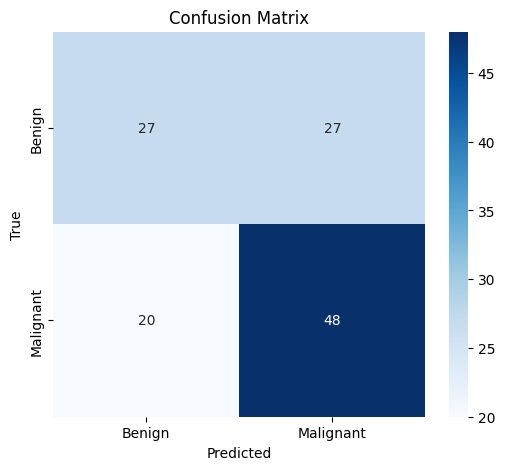

In [17]:
# Previsões
y_pred_prob = model_clf.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
y_true = np.concatenate([labels.numpy() for imgs, labels in test_ds], axis=0)

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#!jupyter nbconvert --to pdf ProjetoFinal.ipynb


[NbConvertApp] Converting notebook ProjetoFinal.ipynb to pdf
[NbConvertApp] Support files will be in ProjetoFinal_files/
[NbConvertApp] Making directory ./ProjetoFinal_files
[NbConvertApp] Writing 84694 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 122384 bytes to ProjetoFinal.pdf
